# Problem set 1 - Ph.D. course in Household Finance
## Morteza Aghajanzadeh

## Problem Description
The problem requires us to simulate a life-cycle model of a household's consumption and savings decisions. The model has two periods: a working period and a retirement period. The household has access to a risky asset and faces uncertainty about future income. The goal is to find the optimal consumption and savings decisions for the household in each period.
### Note: 
For this code, I use library programmed by myself, Toolkit.py which has all the functions needed in the model.

## Part 1
### My Approach
I followed the following steps to solve the problem:

1. I solved the problem of HH for the **retirement** periods, agents solve the problem conditional on age.

2. I then solved the problem for the **working** periods, where again, agents solve the problem for each given year.

3. Now we solved the problem for two period, then we can simulate the model by using the calculated policy functions.

4. At the end, report the life-cycle profiles for different wealth percentile at the retirement and initial wealth



In [1]:
import Toolkit as tk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
########## Model Parameters ##########
β = 0.945 ## Discount factor
γ = 2.0 ## Risk Aversion
start = 25 ## starting age
start += 1 ## first period of life
t_w = 40 ## working age
t_r = 35 ## retirement age
t_r -= 1 ## last period of life
T = t_w + t_r ## total periods
λ = 0.6  ## replacement rate
Y_lower = 4.8
rw = 0.02 ## Interest rate when working
rr = 0.02 ## Interest rate when retired
######### Thresholds ##########
vmin = -1.e10
epsilon = tk.epsilon



## Income Process Parameters

In [3]:
########## Income Process Parameters ##########
## Trend
g_t = pd.read_excel('Income_profile.xlsx')['Y'].to_numpy().flatten() ## Income profile
# trend_pension = λ * g_t[t_w-1]

## Permanent Income Process
N_z = 15  ## number of states for the permanent income process
μ_z = 0.0 ## mean of the permanent income process
ρ_z = 1 ## persistence of the permanent income process
σ_η = 0.015   ## standard deviation of the permanent income process
Z,π_z = tk.tauchenhussey(N_z, μ_z, ρ_z, σ_η)
Z = np.exp(Z)[0].reshape(N_z,1) ## permanent income process

## Transitory Income Process
N_ω = 5 ## number of states for the transitory income process
μ_ω = 0.0 ## mean of the transitory income process
ρ_ω = 0 ## iid process
σ_ω = 0.1  ## standard deviation of the transitory income process
ω,π_ω = tk.tauchenhussey(N_ω, μ_ω, ρ_ω, σ_ω)
ω = np.exp(ω)[0].reshape(N_ω,1) ## transitory income process

π = np.kron(π_z, π_ω) ## transition matrix for the income process

π.shape

(75, 75)

## Simulation Parameters

In [4]:
########## Simulation Parameters ##########
set_seed = 13990509
np.random.seed(set_seed)
N = 1000
μ_A = 1.916 
σ_A = 2.129
A = np.random.normal(μ_A - σ_A**2 / 2, σ_A, N)
A = np.exp(A)
A[A < 0] = 0

μ_z = 0.0
σ_z = 0.015
Z0 = np.exp(np.random.normal(μ_z - σ_z**2 / 2 , σ_z, N))
ε_z = np.random.normal(-σ_z**2/2, σ_z, (N,T))

μ_ω = 0.0
W0 = np.exp(np.random.normal(μ_ω - σ_ω**2 / 2 , σ_ω, N))
ε_ω = np.exp(np.random.normal(μ_ω-σ_ω**2, σ_ω, (N,T)))



######### Thresholds ##########
vmin = -1.e10

## Creating Asset Grid

In [5]:
########## Asset Grid ##########
a_max = 150 ## upper bound of the grid for assets
ϕ = 0  ## Borrowing Constraint
N_a = 200 ## number of grid points for assets
# a_grid = np.linspace(ϕ, a_max, N_a).reshape(N_a,1) ## linear grid for assets
a_grid = tk.discretize_assets_single_exp(ϕ, a_max, N_a).reshape(N_a,1) ## double exponential grid for assets

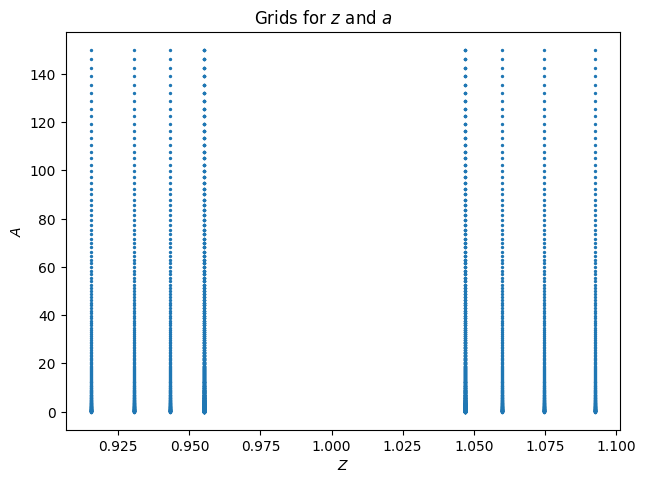

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

s_grid,a_grid_2 = np.meshgrid(Z,a_grid,indexing='ij')
ax.scatter(s_grid,a_grid_2,2)

ax.set_yscale('linear')
ax.set_xlabel('$Z$')
ax.set_ylabel('$A$')

fig.suptitle('Grids for $z$ and $a$')
fig.tight_layout(pad=0.5)

## Retirement Problem

In the retirement period, there is no uncertainty about the future so the HH's problem is
$$
\max_{A_t}\quad u(X_t - A_t) + \beta V(A_{t+1})
$$

In [7]:
Vr, Cr, Xr = tk.retirement(N_a,a_grid, rr, β, γ, t_r, t_w, g_t, λ,vmin)
# Vr is the value function for retirement
# Cr is the consumption function for retirement
print(Vr.shape, Cr.shape, Xr.shape)

(201, 34) (201, 34) (201, 34)


c:\Github\Household-Finance\Part I - Life cycle consumption savings models\Problem set 1\Toolkit.py:98: RuntimeWarning: divide by zero encountered in reciprocal
  Vr[1:,-1:] = Cr[1:,-1:]**(1-γ)/(1-γ)


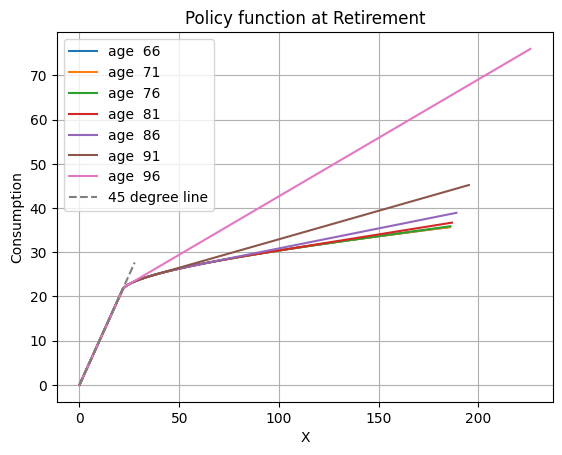

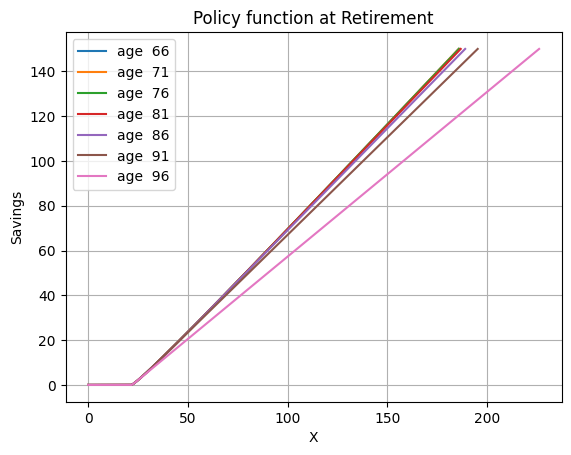

In [8]:
tk.plot_policy_over_ages(Xr,Cr,t_r,'Retirement', N_a, start, t_w,line45=True, yaxis='Consumption')
Sr = Xr - Cr
tk.plot_policy_over_ages(Xr,Sr,t_r,'Retirement', N_a, start, t_w,line45=False, yaxis='Savings')


## Working problem

HH's problem is
$$
\max_{A_t}\quad u(X_t - A_t) + \beta E{[V(A_{t+1})]}
$$

In [9]:
Vw, Cw, Xw = tk.working(N_z, N_ω, N_a, a_grid, Z, ω, π, rw, rr, Xr, Cr, Vr, β, γ, t_w, g_t,λ,vmin)
# Vw is the value function for working
# Cw is the consumption function for working
print(Vw.shape, Cw.shape, Xw.shape)

(3015, 40) (3015, 40) (3015, 40)


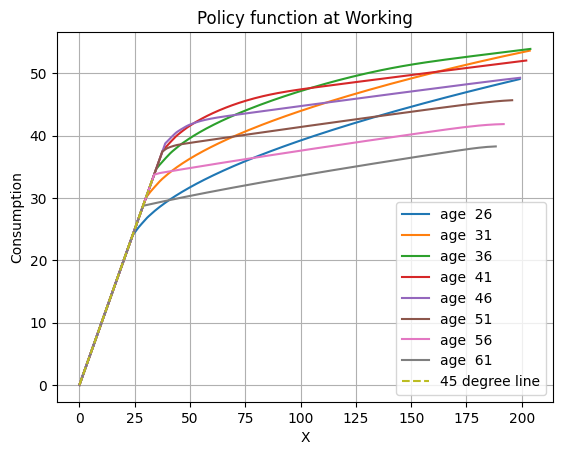

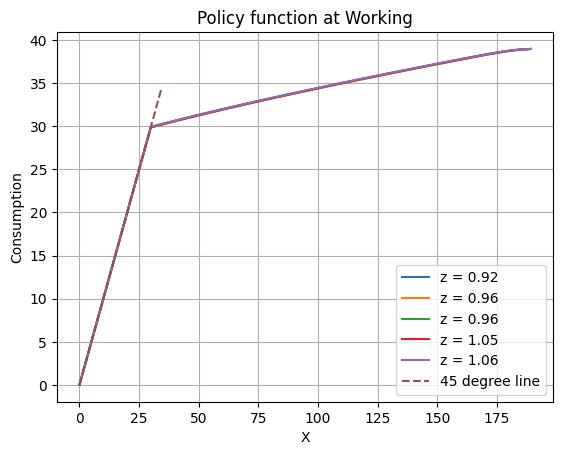

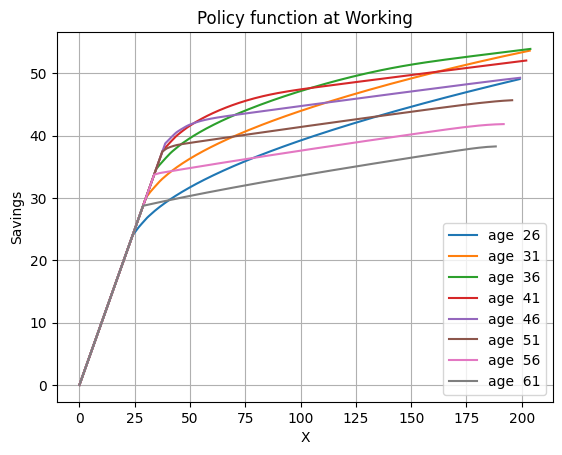

In [10]:
tk.plot_policy_over_ages(Xw,Cw,t_w,'Working', N_a, start, 0,line45=True, yaxis='Consumption')
tk.plot_policy_over_states(Xw,Cw,Z,20,t_w,start,N_z,N_a,line45=True,yaxis='Consumption')
Sw = Xw - Cw
tk.plot_policy_over_ages(Xw,Cw,t_w,'Working', N_a, start, 0,line45=False, yaxis='Savings')

## Simulation

Simulated model for working age
Simulated model for retirement age


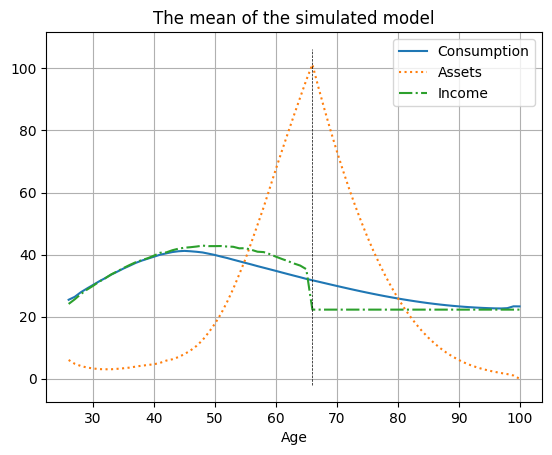

In [11]:
A_sim, Z_sim, ω_sim, income_sim, Zi_sim, X_sim, C_sim =  tk.simulate_model(T, rw, rr, Xw, Cw, Y_lower, t_w, t_r, g_t, ρ_z, N, N_a, Xr, Cr, Z, λ, ε_z, ε_ω, A, Z0,start)

## Plot the individual person 


In [13]:
def plot_specific_person(A_index,ax=False):
    if ax != False:
        plt.sca(ax)
    C_mean = C_sim[A_index,:]
    plt.plot(range(start,start + T+1),C_mean)
    A_mean = A_sim[A_index,:]
    plt.plot(range(start,start + T+1),A_mean,linestyle=':')
    I_mean = income_sim[A_index,:]
    plt.plot(range(start,start + T+1),I_mean,linestyle='-.')
    # plt.plot(range(start,start + T+1),np.zeros(T+1),linestyle='--')
    max_value = max(C_mean.max(),A_mean.max(),I_mean.max())
    plt.plot([start + t_w]*100,np.linspace(-2,max_value + 5,100),linestyle='--',color='black',linewidth=0.5)
    plt.legend(['Consumption','Assets','Income'])
    plt.grid()
        
    

### Individual Life-Cycle results

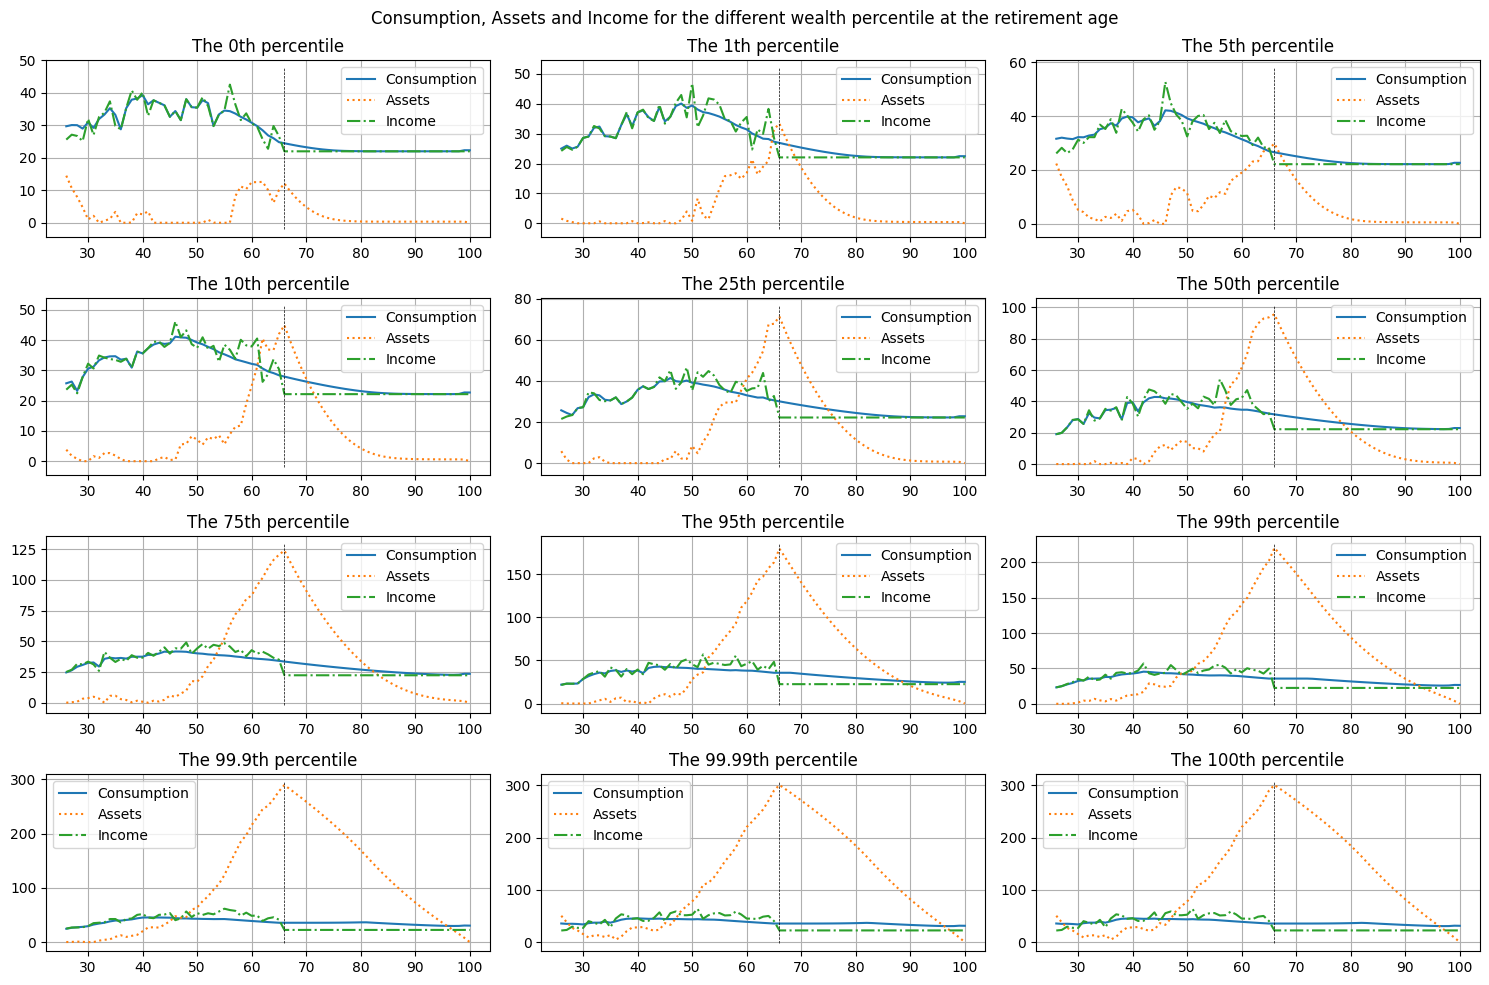

In [14]:
percentiles = [0,1,5,10,25,50,75,95,99,99.9,99.99,100]
fig, axs = plt.subplots(int(len(percentiles)/3), 3, figsize=(15, 10))
axs = axs.flatten()
counter = 0
for i, ax in zip(percentiles, axs):
    tempt = np.abs(A_sim[:, start + t_w] - np.percentile(A_sim[:, start + t_w],i))
    A_index = np.where(tempt == tempt.min())[0][0]
    plot_specific_person(A_index,ax=ax)
    # plt.show()
    ax.set_title('The {}th percentile'.format(i))

fig.suptitle('Consumption, Assets and Income for the different wealth percentile at the retirement age')
plt.tight_layout()
plt.show()

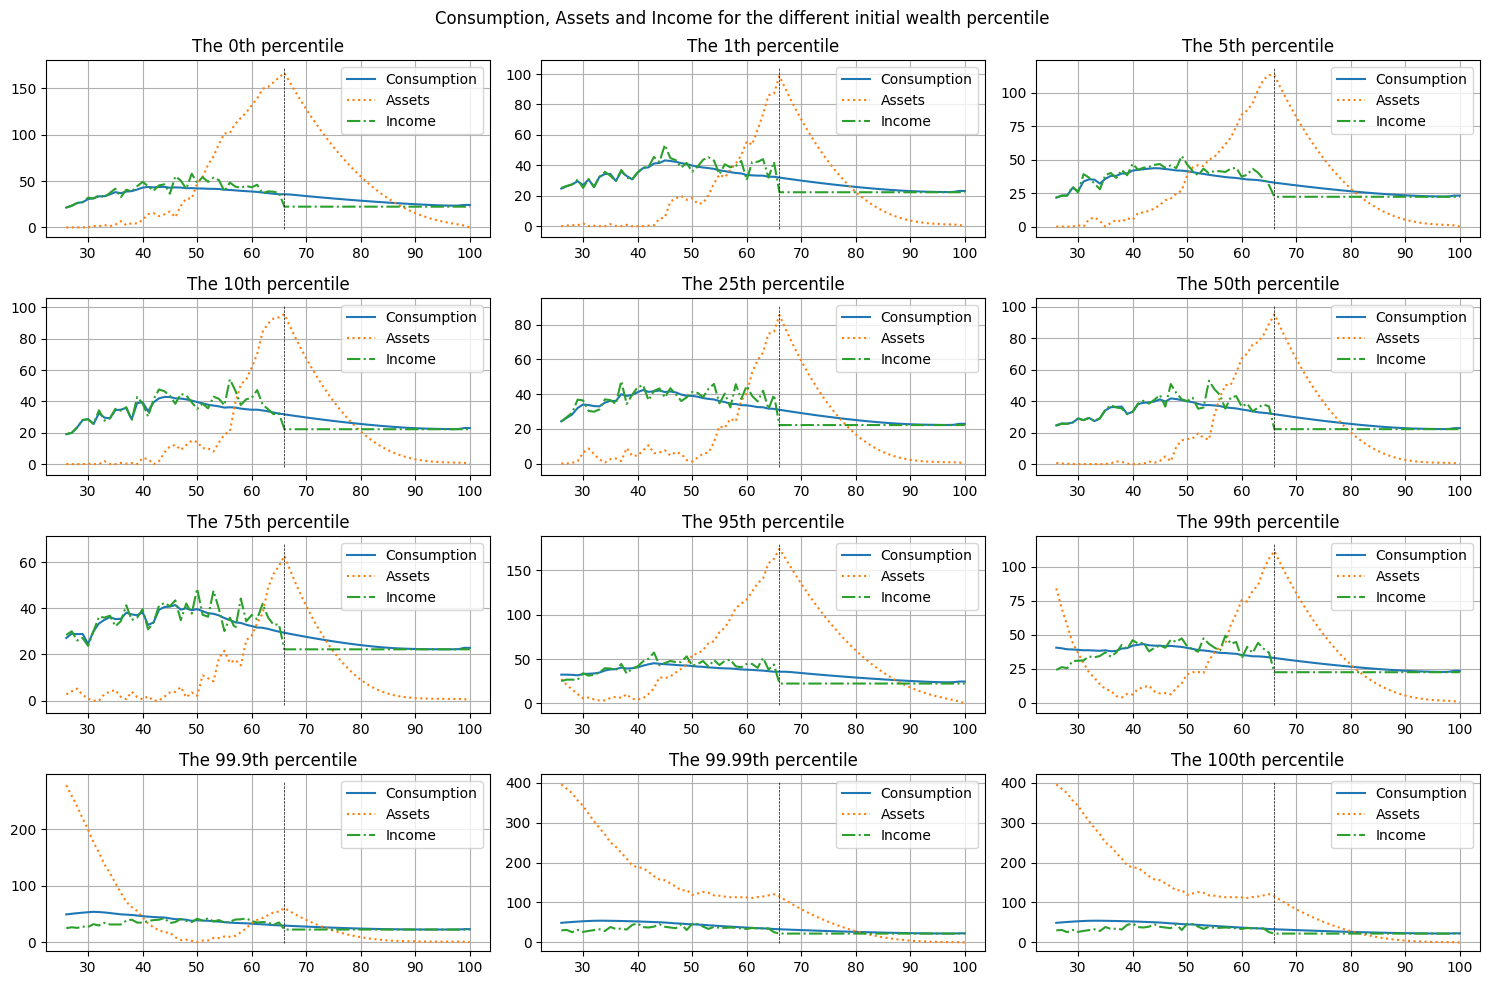

In [15]:
percentiles = [0,1,5,10,25,50,75,95,99,99.9,99.99,100]
fig, axs = plt.subplots(int(len(percentiles)/3), 3, figsize=(15, 10))
axs = axs.flatten()

for i, ax in zip(percentiles, axs):
    tempt = np.abs(A_sim[:, 0] - np.percentile(A_sim[:, 0],i))
    A_index = np.where(tempt == tempt.min())[0][0]
    plot_specific_person(A_index,ax=ax)
    ax.set_title('The {}th percentile'.format(i))

fig.suptitle('Consumption, Assets and Income for the different initial wealth percentile ')
plt.tight_layout()
plt.show()

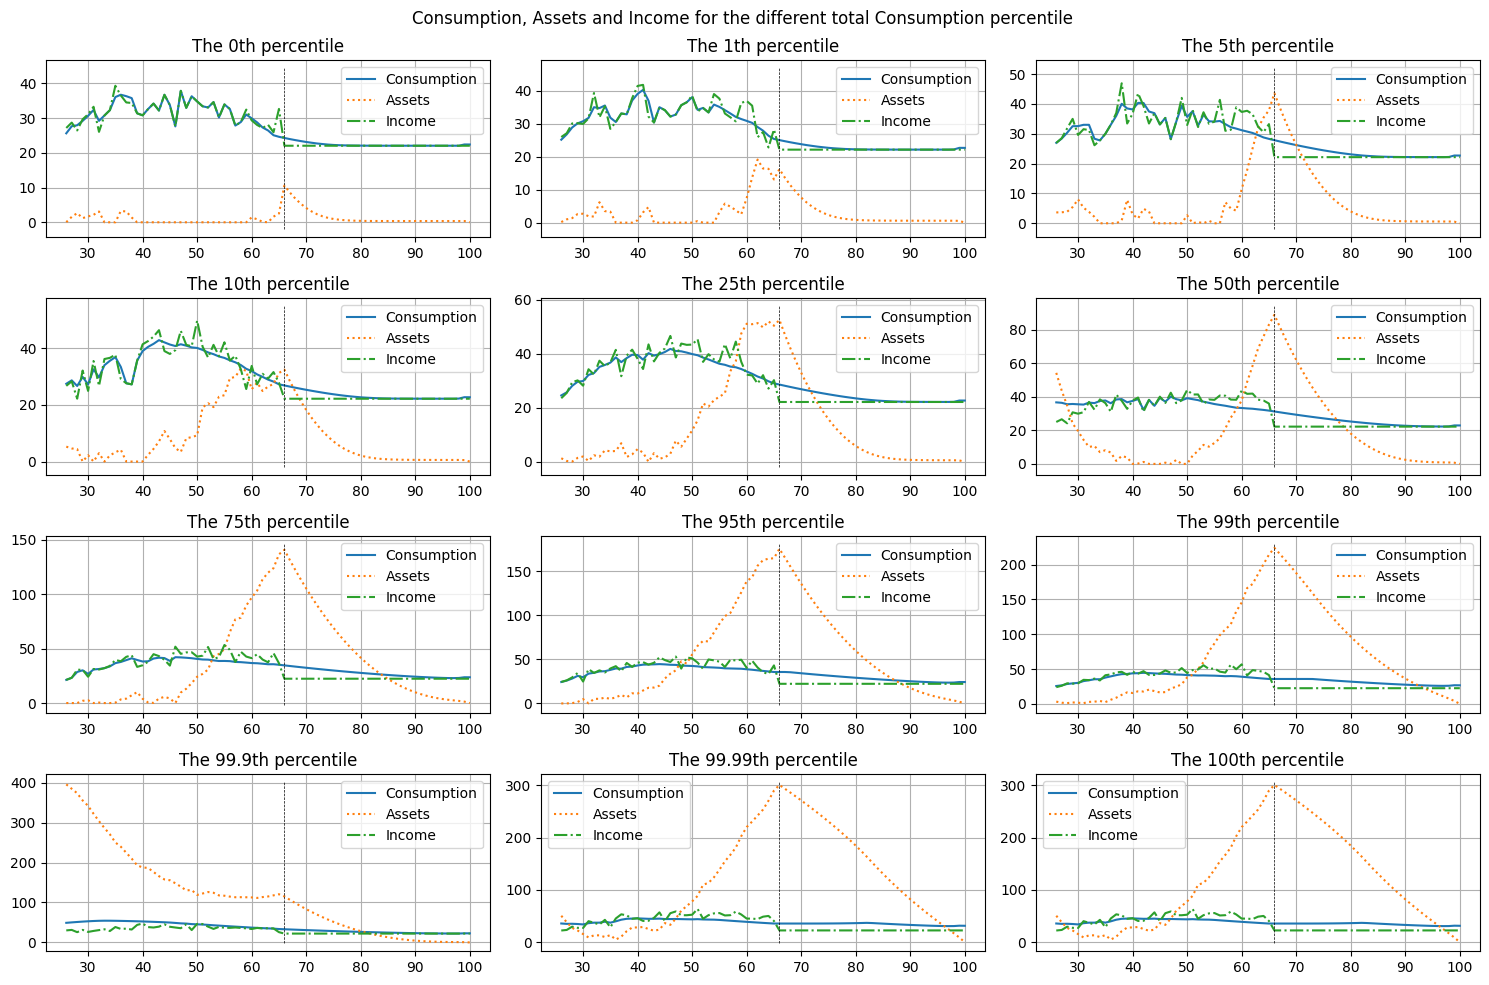

In [28]:
percentiles = [0,1,5,10,25,50,75,95,99,99.9,99.99,100]
fig, axs = plt.subplots(int(len(percentiles)/3), 3, figsize=(15, 10))
axs = axs.flatten()

tempt_1 = C_sim.sum(axis=1)

for i, ax in zip(percentiles, axs):
    tempt = np.abs(tempt_1[:] - np.percentile(tempt_1,i))
    A_index = np.where(tempt == tempt.min())[0][0]
    plot_specific_person(A_index,ax=ax)
    ax.set_title('The {}th percentile'.format(i))

fig.suptitle('Consumption, Assets and Income for the different total Consumption percentile ')
plt.tight_layout()
plt.show()

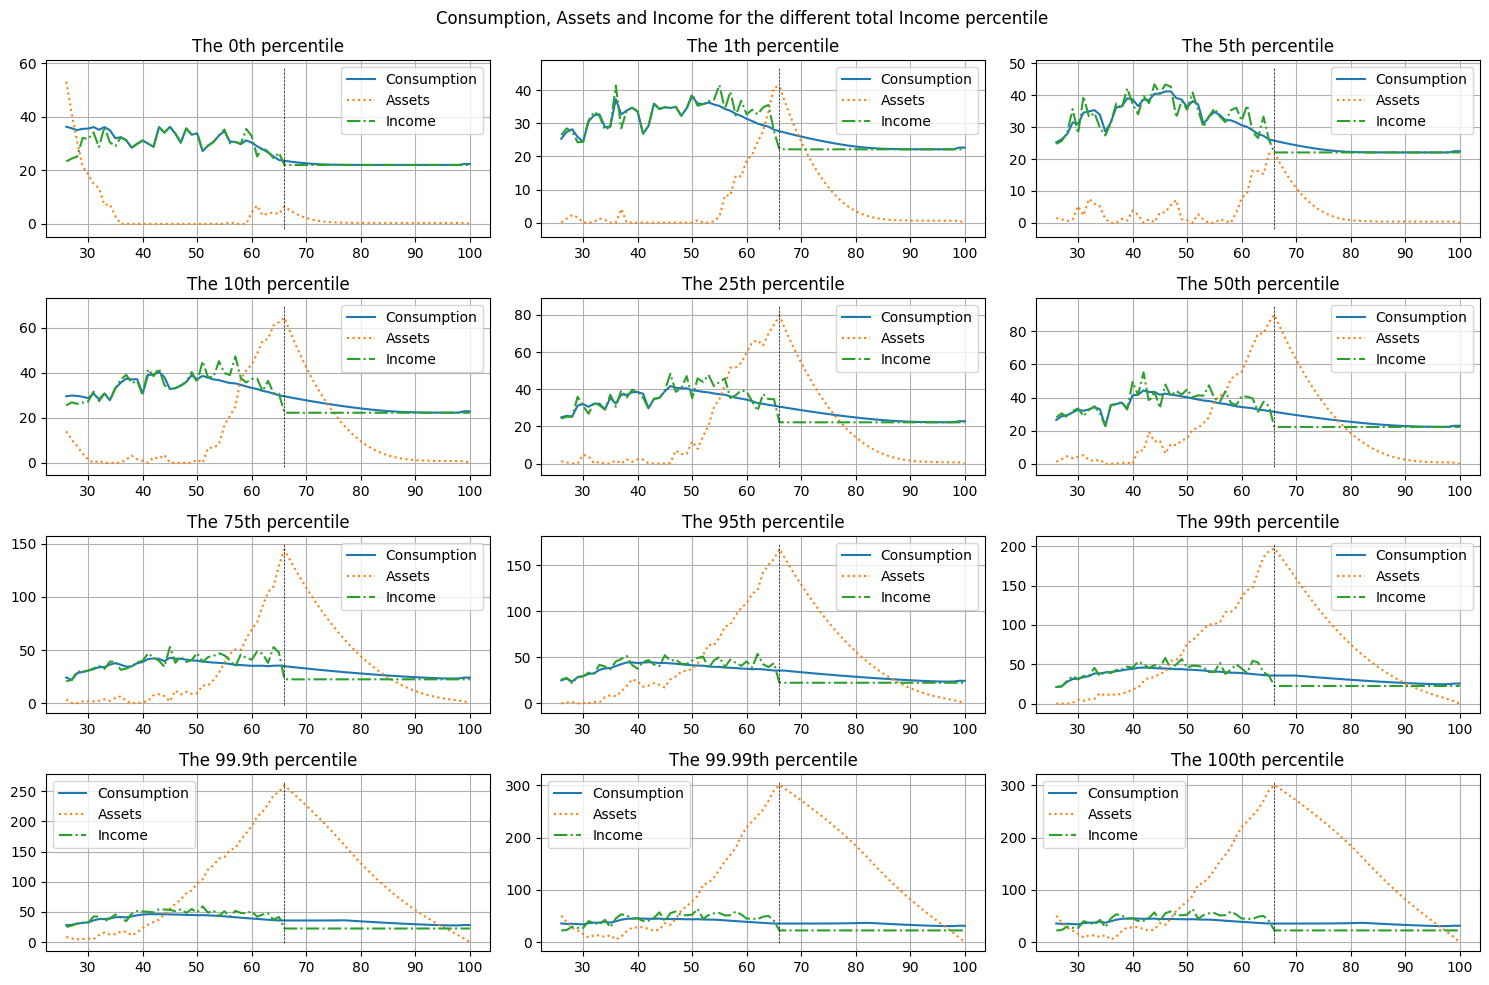

In [29]:
percentiles = [0,1,5,10,25,50,75,95,99,99.9,99.99,100]
fig, axs = plt.subplots(int(len(percentiles)/3), 3, figsize=(15, 10))
axs = axs.flatten()

tempt_1 = income_sim.sum(axis=1)

for i, ax in zip(percentiles, axs):
    tempt = np.abs(tempt_1[:] - np.percentile(tempt_1,i))
    A_index = np.where(tempt == tempt.min())[0][0]
    plot_specific_person(A_index,ax=ax)
    ax.set_title('The {}th percentile'.format(i))

fig.suptitle('Consumption, Assets and Income for the different total Income percentile ')
plt.tight_layout()
plt.show()

## Part 2

## My Approach:

1. I define a new state variable **r** which is following the 
$$
R_t = \exp(\ln{R^f} + \mu + \varepsilon_t)
$$
2. I define a function that solve the problem for given *X* and *C*.
3. Now it is the time to solve the problem for the HH during the retirement. As you know, problem for the retirement period is simpler, due to the fact that we only have one state variable 
4. I need to solve the model for the working period too, which I **could not!**
5. I put a lot of time, but it is still ongoing.

### Conclusion:
The main problem is the fact that the *alpha* function is not concave, and we have **multiple solutions**!

In [17]:
Z, ω, π_ω, π_z, π, A, Z0, ε_z, ε_ω,a_grid = tk.initialize(T,N_z, μ_z, ρ_z, σ_η,N_ω,μ_ω,ρ_ω,σ_ω,N_a,a_max,ϕ,N,μ_A,σ_A,σ_z)

## Shock in the interest rate
N_r = 5 ## number of states for the interest rate process
μ = 0.04 
r_f = 0.02
μ_r = np.log(1+r_f) + μ
σ_r = 0.18
r,π_r = tk.tauchenhussey(N_r, μ_r, 0, σ_r)
r = np.exp(r)[0].reshape(N_r,1) ## transitory income process
print(r)
r = r - 1

σ_r = 0.18
ε_r = np.exp(np.random.normal(-σ_r**2, σ_r, (N,T)))

N_α = 5
α_grid = np.linspace(0,1,N_α)
π = np.kron(np.kron(π_r, π_z), π_ω)

[[0.70767015]
 [0.8757767 ]
 [1.06162699]
 [1.28691694]
 [1.59262316]]


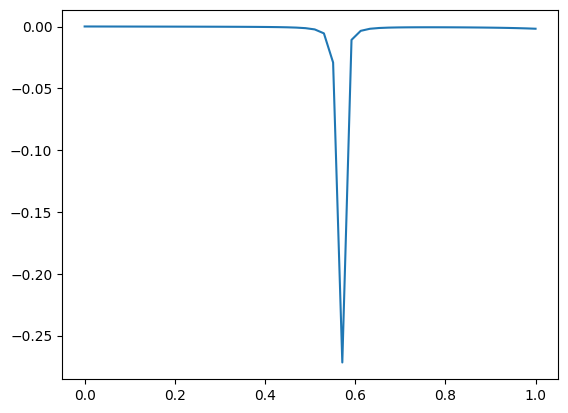

In [20]:
x = Xr[-5,5]
c = Cr[-5,5]
a = a_grid[-5]
α = 0.5
r_state = 0
r_index = r_state
z_state = 0
pension =  λ * g_t[t_w-1]
income = pension
def alpha(α,x,c,a,r_index,π_r,pension):
    A_t = x - c
    Y_t1 = pension 
    X_t1 = Y_t1 +  A_t* (1 + r_f + α * (r - r_f)).T 
    c_t1 = X_t1 - a
    # c_t1 = np.interp(c_t1,Xr[:,t+1], Cr[:,t+1])
    M_t1 = β * c_t1 ** (-γ)  
    # E =  (M_t1 * (r - r_f).T) @ π_r[i,:].T
    E =  (M_t1 * (r - r_f).T) @ π_r[r_index,:].T
    return E[0]

def alpha(α,x,c,a,r_index,π_r,income):
    A_t = x - c
    Y_t1 = income 
    X_t1 = Y_t1 +  A_t* (1 + r_f + α * (r - r_f)).T 
    c_t1 = X_t1 - a
    M_t1 = β * c_t1 ** (-γ)  
    E =  (M_t1 * (r - r_f).T) @ π_r[r_index,:].T
    return E[0]

test_a = np.linspace(0,1,50)
res = []
for i in test_a:
    # res.append(alpha_stocastic_income(i,x,c,a,r_state,z_state,π_r,π_z,income))
    res.append(alpha(i,x,c,a,r_state,π_r,pension))
plt.plot(test_a,res)

In [23]:
from scipy.optimize import fsolve
def alpha(α,x,c,a,r_index,π_r,income):
    A_t = x - c
    Y_t1 = income 
    X_t1 = Y_t1 +  A_t* (1 + r_f + α * (r - r_f)).T 
    c_t1 = X_t1 - a
    M_t1 = β * c_t1 ** (-γ)  
    E =  (M_t1 * (r - r_f).T) @ π_r[r_index,:].T
    return E[0]


def solve_alpha(x,c,a,r_index,π_r,income):
    alpha_0 , alpha_1 = alpha(0,x,c,a,r_index,π_r,income),alpha(1,x,c,a,r_index,π_r,income)
    if alpha_0 * alpha_1 > 0:
        if alpha_0 > 0: return 1
        else: return 0
    else:
        α = fsolve(alpha,0.5,args = (x,c,a,r_index,π_r,income))[0]
        if α >1: return 1
        else: return α

def solve_over_array(X,C,grid,r_index,π_r,income):
    αp = np.zeros((N_a,1))
    for n_a in range(0,N_a):
        αp[n_a] = solve_alpha(X[n_a],C[n_a],grid[n_a],r_index,π_r,income)
    return αp
    # αp = np.zeros((N_a,1))
    # for n_a in range(0,N_a):
    #     αp[n_a] = solve_alpha(Xp[n_a],Cp[n_a],a_grid[n_a],r_index = i,π_r = π_r,pension = pension)


def retirement_with_asset(r,π_r,γ,β,λ,g_t,t_w,t_r,N_a,a_grid,vmin):
    Vr = np.zeros((N_r * (N_a+1), t_r))
    Cr = np.zeros((N_r * (N_a+1), t_r))
    Xr = np.zeros((N_r * (N_a+1), t_r))
    αr = np.zeros((N_r * (N_a+1), t_r))

    # Set the last period
    for i in range(N_r):
        Vr[i*(N_a+1),:] = vmin
        index = range(i*(N_a+1)+1,(i+1)*(N_a+1))
        Xr[index,-1:] = a_grid 
        Cr[index,-1:] = Xr[index,-1:]
        Vr[index,-1:] = Cr[index,-1:]**(1-γ)/(1-γ)
        
    # backward iteration
    for t in range(t_r-1,0, -1):
        t -= 1
        # I have to think more about the pension income
        pension = λ * g_t[t_w-1]
        Cp = np.zeros((N_a,N_r))
        Vp = np.zeros((N_a,N_r))
        for i in range(N_r):
            Xp = a_grid * (1 + r[i]) + pension ## cash-on-hand tomorrow
            index = range(i*(N_a+1)+1,(i+1)*(N_a+1))
            Cp[:,i:i+1] = np.interp(Xp,Xr[index,t+1], Cr[index,t+1]) # interpolate consumption
            Vp[:,i:i+1] = np.interp(Xp,Xr[index,t+1], Vr[index,t+1]) # interpolate consumption
            for n_a in range(0,N_a):
                index = i*(n_a+1)+1
                αr[index,t:t+1] = solve_alpha(Xp[n_a],Cp[n_a,i:i+1],a_grid[n_a],r_index = i,π_r = π_r,income = pension)
        dVp = Cp ** (-γ) 
        EV = β * np.dot(dVp,π_r.T)
        for i in range(N_r):
            index = range(i*(N_a+1)+1,(i+1)*(N_a+1))
            dV = β * np.dot(dVp,π_r[i,:].T) * (1 + r[i])
            Cr[index,t:t+1] = dV.reshape(dV.shape[0],1) ** (-1/γ)
            Xr[index,t:t+1] = Cr[index,t:t+1] + a_grid
    return Cr,Xr,Vr,αr
Cr,Xr,Vr,αr = retirement_with_asset(r,π_r,γ,β,λ,g_t,t_w,t_r,N_a,a_grid,vmin)


C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


array([0.6971274])

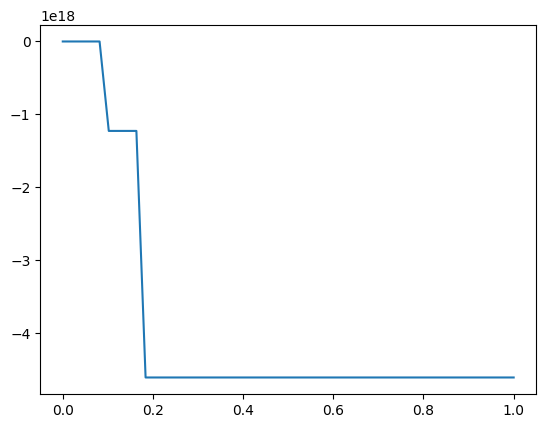

In [24]:
x = Xr[-1,5]
c = Cr[-1,5]
a = a_grid[-1]
α = 0.5
r_state = 0
z_state = 0
income = Z
def alpha_stocastic_income(α,x,c,a,r_state,z_state,π_r,π_z,income):
    A_t = x - c
    Y_t1 = income 
    X_t1 = Y_t1 +  A_t* (1 + r_f + α * (r - r_f)).T 
    c_t1 = X_t1 - a
    c_t1[c_t1<0] = epsilon
    M_t1 = β * c_t1 ** (-γ)  
    r_repeated = np.kron(r,np.ones((1,N_z))).T
    E =  ((M_t1 * (r_repeated - r_f)) @ π_r[r_state,:]).T @ π_z[z_state,:]
    return E

test_a = np.linspace(0,1,50)
res = []
for i in test_a:
    res.append(alpha_stocastic_income(i,x,c,a,r_state,z_state,π_r,π_z,income))
plt.plot(test_a,res)
fsolve(alpha,1,args = (x,c,a,r_state,π_r,pension))